In [1]:
# import sys
# sys.path.append("../")

########################
## tesing simulations ##

from sim_handling import Simulation
from sim_handling_new import SimulationNew
import diffusion as df
import diffusionstuff7 as ds
########################
# import numpy as np
# from matplotlib import pyplot as plt
from matplotlib import rcParams
import time
# import diffusionstuff6_1 as ds
from copy import copy as dup
from scipy.integrate import odeint

######################
## testing 0d stuff ##

# from diffusion import getsigmastep ## this was never changed, matches diffusionstuff7's version exactly
# from diffusion import f0d as f0dNew
# from diffusionstuff7 import f0d as f0dOld
######################


######################
## testing 1d stuff ##

# from diffusion import getsigmastep ## this was never changed, matches diffusionstuff7's version exactly
# from diffusion import f1d as f1dNew
# from diffusionstuff7 import f1d as f1dOld
######################


######################
## testing 2d stuff ##

# from diffusion import getsigmastep_2d ## this was never changed, matches diffusionstuff7's version exactly
# from diffusion import f2d as f2dNew
# from diffusionstuff7 import f2d as f2dOld
######################


#######################
## necessary imports ##

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rcParams
from scipy.integrate import solve_ivp

In [2]:
%matplotlib widget
# ticklabelsize = 15
# fontize = 15
# linewidth = 2
# fignum = 0

# testing from continuum model

In [3]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rcParams
import time
from copy import copy as dup
from scipy.integrate import odeint
from scipy.integrate import solve_ivp

In [11]:
def getsigmaI(x,xmax,center_reduction,sigmaIcorner,method='sinusoid'):
    sigmapfac = 1-center_reduction/100
    xmid = max(x)/2
    if method == 'sinusoid':
        fsig = (np.cos(x/xmax*np.pi*2)+1)/2*(1-sigmapfac)+sigmapfac
    elif method == 'parabolic':
        fsig = (x-xmid)**2/xmid**2*(1-sigmapfac)+sigmapfac
    else:
        print('bad method')
    return fsig*sigmaIcorner

def f1d_sigma_m(y, t, params):
    Nbar, Nstar, sigmaI, sigma0, deprate, Doverdeltax2, nx = params
    Ntot0 = y      # unpack current values of y

    Nqll0 = Nbar - Nstar * np.sin(2*np.pi*(Ntot0))
    
    # Deposition
    m = (Nqll0 - (Nbar - Nstar))/(2*Nstar)
    sigma_m = (sigmaI - m * sigma0)/(1+m*sigma0)
    return sigma_m





def diffuse_1d(Ntot, Nstar, D, overX):
    l = len(Ntot)
    dy = np.zeros((l,))
    
    # print(l)
    
    coef = D*Nstar*4*np.pi**2
    for i in range(1,-1):#(1,l-1):
        dy1st = 2*np.pi * (np.sin(2*np.pi*Ntot[i+1]*(overX*Ntot[i+1])**2) - 2 * np.sin(2*np.pi*Ntot[i]*(overX*Ntot[i])**2) + np.sin(2*np.pi*Ntot[i-1]*(overX*Ntot[i-1]))**2)
        dy2nd = - overX**2 * (Ntot[i+1]*np.cos(2*np.pi*Ntot[i+1]) - 2 * Ntot[i]*np.cos(2*np.pi*Ntot[i]) + Ntot[i-1]*np.cos(2*np.pi*Ntot[i-1]))
        dy[i] = coef * (dy1st * dy2nd)
    ##dy[1:-1] = DoverdeltaX2 * (Fliq0[:-2] - 2 * Fliq0[1:-1] + Fliq0[2:])
    #boundary conditions
    dy[0] = coef * (2*np.pi * (np.sin(2*np.pi*Ntot[1]*(overX*Ntot[1])**2) - 2 * np.sin(2*np.pi*Ntot[0]*(overX*Ntot[0])**2) + np.sin(2*np.pi*Ntot[-1]*(overX*Ntot[-1]))**2) - overX**2 * (Ntot[1]*np.cos(2*np.pi*Ntot[1]) - 2 * Ntot[0]*np.cos(2*np.pi*Ntot[0]) + Ntot[-1]*np.cos(2*np.pi*Ntot[-1])))
    dy[l-1] = coef * (2*np.pi * (np.sin(2*np.pi*Ntot[0]*(overX*Ntot[0])**2) - 2 * np.sin(2*np.pi*Ntot[-1]*(overX*Ntot[-1])**2) + np.sin(2*np.pi*Ntot[-2]*(overX*Ntot[-2]))**2) - overX**2 * (Ntot[0]*np.cos(2*np.pi*Ntot[0]) - 2 * Ntot[-1]*np.cos(2*np.pi*Ntot[-1]) + Ntot[-2]*np.cos(2*np.pi*Ntot[-2])))

    return dy


# @njit("f8[:](f8,f8[:],f8[:])",parallel=prll_1d)#slower with paralellization right now
def f1d(t,y,  float_params): #sigmastep is an array
    ##NOTE: NESH CHANGED sigmastep = getsigmastepmax TO sigmaIcorner as a param = 0.22
    # print(float_params)
    Nbar, Nstar, sigma0, deprate, sigmaI, D, deltaX = float_params 

    Ntot0 = np.ascontiguousarray(y)

    ## Ntot is passed in, Fqll calculated from Ntot
    Nqll0 = Nbar - Nstar * np.sin(2*np.pi*(Ntot0))
    ## WHY??? still unsure about this one....
    m = (Nqll0 - (Nbar - Nstar))/(2*Nstar)
    sigM = (sigmaI - m * sigma0)/(1+m*sigma0)
    depsurf = deprate * sigM
    dNtot_dt = depsurf
    # Diffusion
    # dy = diffuse_1d(Nqll0,DoverdeltaX2)
    dy = diffuse_1d(Ntot0,Nstar,D,deltaX)
    dNtot_dt += dy 
    ## Package for output, only values of dNtot
    derivs = dNtot_dt
    return derivs

0.8333333333333334
sinusoid: 357.11646835877116
paraboloic: 329.5682114433066
D = 0.00016 um^2/us 0.16 x 10^-9 m^2/sec
deltat_max (Diffusion time) = 562.4999999999999
deltat = 11.249999999999998
deprate = 0.8333333333333334 monolayers/us
nmid = 250
N* = 0.1432394487827058
N*x2pi = 0.9
Nbar, Nbar-N*, N*/Nbar = 1.0 0.8567605512172942 0.1432394487827058
deltax = 0.3
sigma_0 = 0.19
sigmaIcorner = 0.22
center reduction = 0.25 %
c_r = 0.0025 dimensionless
max growth rate = 55.00000000000001 um/sec
min growth rate = 7.5 um/sec
nu_kin = 250 um/sec
dx = 0.3
L = 75.0 micrometers


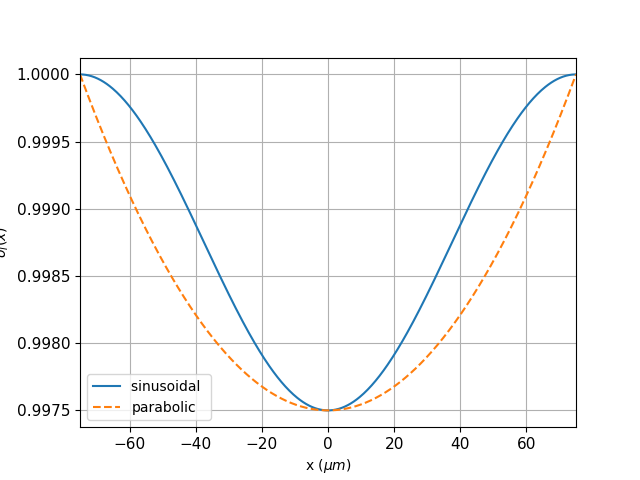

In [12]:
#Setting up the system
nx = 501 # Number of points in simulation box
# nx = 1501 # Number of points in simulation box
xmax = 50
xmax = 150
x = np.linspace(0, xmax, nx)
boxpoints = len(x)
deltax = x[1]-x[0]
Nbar = 1.0 # new Nbar from VMD, 260K
Nstar = .9/(2*np.pi)

# Initialize as a pre-equilibrated layer of liquid over ice
Ntot = np.ones(nx)
NQLL = Nqll = Nbar - Nstar*np.sin(2*np.pi*(Ntot))##ds.getNliq(Ntot,Nstar,Nbar)
Nice = Ntot-NQLL

# Lay out the system
Ntot = NQLL + Nice


nmid = int(nx/2)
nquart = int(nx/4)
xmid = max(x)/2
xmax = x[nx-1]
Nice_start = Nice[0]

# Just conversions
nmpermonolayer = 0.3
umpersec_over_mlyperus = (nmpermonolayer/1e3*1e6)

# Diffusion coefficient
# D = 2e-4 # micrometers^2/microsecond
D = 1.6e-4 # micrometers^2/microsecond
# D = 5e-5 # micrometers^2/microsecond
# D = 8e-6 # micrometers^2/microsecond
# D = 2e-7 # micrometers^2/microsecond

# Time steps
dtmaxtimefactor = 50
dtmax = deltax**2/D
deltat = dtmax/dtmaxtimefactor

# Deposition rate
nu_kin = 34 # microns/second - about right for 240 K
nu_kin = 49 # microns/second - between 240 and 260 K
nu_kin = 250 # microns/second - about right for 260 K
deprate = nu_kin/umpersec_over_mlyperus # monolayers per microsecond
deprate_times_deltat = deprate * deltat

# Supersaturation
sigma0 = 0.19
sigmaIcorner = 0.20 # Must be bigger than sigma0 to get growth
sigmaIcorner = 0.22 # Must be bigger than sigma0 to get growth
center_reduction = 0.15 # In percent
c_r = center_reduction/100

# Diffusion coefficient scaled for this time-step and space-step
Doverdeltax2 = D/deltax**2

# Gets the function sigma(x)
sigmaI_sinusoid = getsigmaI(x,xmax,center_reduction,sigmaIcorner,method='sinusoid') #NOTE i think this should be nx not xmax
sigmaI_parabolic = getsigmaI(x,xmax,center_reduction,sigmaIcorner,method='parabolic')
sigmaIstyle = 'sinusoid'
# sigmaIstyle = 'parabolic'
if sigmaIstyle=='sinusoid':
    sigmaI = sigmaI_sinusoid
elif sigmaIstyle=='parabolic':
    sigmaI = sigmaI_parabolic
else:
    print('bad choice')

# Graph sigma(x)
plt.figure()
plt.plot(x-xmid,sigmaI_sinusoid/sigmaIcorner, \
         x-xmid, sigmaI_parabolic/sigmaIcorner, '--')
plt.xlim([-xmid,xmid])
plt.legend(['sinusoidal ', 'parabolic'])
plt.xlabel(r'x ($\mu m$)')
plt.ylabel(r'$\sigma_I(x) $')
plt.grid('on')

# These are run control parameters

# Flag for explicit updating NQLL(Ntot) every step
updatingNQLL = False

# Set up a maximum number of iterations or layers
uselayers = True

# 0D run
if uselayers:
    layermax_0D = 100
else:
    countermax_0D = 100

# 1D run 
if uselayers:
    layermax_1D = 250
else:
    countermax_1D = 15000

#Parameters for 1-D run 
L = xmax/2
c_r = center_reduction / 100; 
nu_kin_ml = deprate; print(nu_kin_ml) # monolayers per microsecond
# sigma_I = sigmaIcorner; print('sigmaI ', sigma_I) # dimensionless
M = np.array([.0027, .0025])
B = np.array([2.9, 1.59])
beta = np.array([0.65, 0.65])
xfactor = nu_kin_ml*L**2*c_r**beta*sigmaIcorner/D
NSS = M*xfactor + B
print('sinusoid:', NSS[0])
print('paraboloic:', NSS[1])
    
# Reporting
print("D =", D, 'um^2/us',D * 1e-12*1e6*1e9, 'x 10^-9 m^2/sec')
print('deltat_max (Diffusion time) =', dtmax)
print('deltat =', deltat)
print('deprate =', deprate, 'monolayers/us')
print('nmid =', nmid)
print('N* =', Nstar)
print('N*x2pi =', Nstar*2*np.pi)
print('Nbar, Nbar-N*, N*/Nbar =', Nbar, Nbar-Nstar, Nstar/Nbar)
print('deltax =', deltax)
print('sigma_0 =', sigma0)
print('sigmaIcorner =', sigmaIcorner)
print('center reduction =', center_reduction, '%')
print('c_r =', c_r, 'dimensionless')
print('max growth rate =', deprate*sigmaIcorner*umpersec_over_mlyperus, 'um/sec')
print('min growth rate =', deprate*(sigmaIcorner-sigma0)*umpersec_over_mlyperus, 'um/sec')
print('nu_kin =', nu_kin, 'um/sec')
print('dx =', deltax)
print('L =', L, 'micrometers')

In [13]:
# Bundle parameters for ODE solver
params = [Nbar, Nstar, sigmaI, sigma0, deprate, D, deltax] 

# Time steps
t0 = 0.0
ttot = 0.0
tinterval = [t0, deltat]

# Initial conditions for ODE solver
y0 = np.array(Ntot)
ylast = dup(y0)

# Initialize the keeper arrays
tkeep = [t0]
Nicekeep = [dup(Nice)]
Ntotkeep = [dup(Ntot)]
NQLLkeep = [dup(NQLL)]
fluxderivskeep = []

# print(Ntot)

# Call the ODE solver
Nice0_start = Nice[0]
Nice0 = Nice[0]
Ntot0_start = Ntot[0]
Ntot0 = Ntot[0]
counter = 0
lastlayer = 0
lastdiff = 0

tlast = dup(t0)




while True:
    # Integrate up to next time step
    # print(np.shape(ylast))
    # y = odeint(df.f1d, ylast, tinterval, args=(params,),rtol=1e-12)
    solve_ivp_result = solve_ivp(f1d, tinterval, np.reshape(ylast,np.prod(np.shape(ylast))), args=(params,))
    y = solve_ivp_result.y[:, len(solve_ivp_result.t)-1]

    # print(np.shape(y))
    ylast = y

    # print(y)

    tlast += deltat
    counter += 1
        
    # Make some local copies, with possible updates to NQLL
    Ntot = ylast
    Nice = Ntot - NQLL
    Nice0 = Nice[0]
    Ntot0 = Ntot[0]
    ttot += deltat

    # Stuff into keeper arrays
    Nicekeep.append(Nice)
    Ntotkeep.append(Ntot)
    NQLLkeep.append(NQLL)
    tkeep.append(ttot)

    # print(layer[0])

    # Update counters and see whether to break
    layer = Ntot0-Ntot0_start
    if (layer-lastlayer) > 0:
        minpoint = min(Nice)
        maxpoint = max(Nice)
        print(counter-1, int(layer), maxpoint-minpoint)
        lastdiff = maxpoint-minpoint
        lastlayer += 1

        # prog = round(layer/(lastlayer-1)*100, 2)
        # print(prog)
    if uselayers:
        if layer > layermax_1D-1:
            print('breaking because reached max number of layers')
            break
    else:
        if counter > countermax_1D-1:
            print('breaking because reached max number of iterations')
            break

0 1 0.018195643340159773
1 2 0.06271652598646549
2 4 0.40341192243747415
3 5 0.2935214628398093
4 7 0.415989063008011
5 8 0.46545389933141124
6 10 0.3950193204069219
7 11 0.5222528946061775
8 12 0.6002260516641229
9 14 0.7717370429461834
10 15 0.7199672298405382
11 16 0.7990463095449947
12 17 1.1682724401707354
13 19 1.4104724155174218
14 20 1.1431412723647405
15 22 1.3940883058344298
16 23 1.4725243520083922
17 24 1.3983533678938294
18 26 1.5969545814579895
19 27 1.8221926400903925
20 28 1.9700654538899691
21 30 2.229500069684157
22 31 2.469413040038731
23 33 2.460522306708768
24 34 2.539943430856745
25 35 2.7405719583920956
26 37 2.9008287282674345
27 38 3.0519091671693346
28 39 2.973507910503166
29 41 3.212038703878399
30 42 3.193959085254548
31 44 3.5243489182816816
32 45 3.3122666539136816
33 47 3.3706527628367766
34 48 3.426571549057499
35 49 3.2117699473364354
36 51 3.0595797565216287
37 52 3.444784655643275
38 53 3.479360128520085
39 55 3.707678667431466
40 56 3.642507604777790

501 Ntot
Height of Ice 0
1-D growth, corner 258.66249521167424
1-D growth, center 259.6607240124584
1-D Modeled growth rate, corner, um/s 37.89926669768121
1-D Modeled growth rate, corner, ml/us 0.1263308889922707
1-D Modeled growth rate, center, um/s 38.04552732783273
1-D Modeled alpha, corner 0.689078664241795
1-D Modeled alpha, center 0.6934705368481701
Difference, % 0.6373543158831557
Libbrecht's predicted growth rate, um/s 10.705216497342732
Libbrecht's predicted alpha 0.19464029995168605
Time taken: 0 min 0.002368927001953125 secs


Text(0.5, 1.0, 'Layer difference (max-min) D=0.00016')

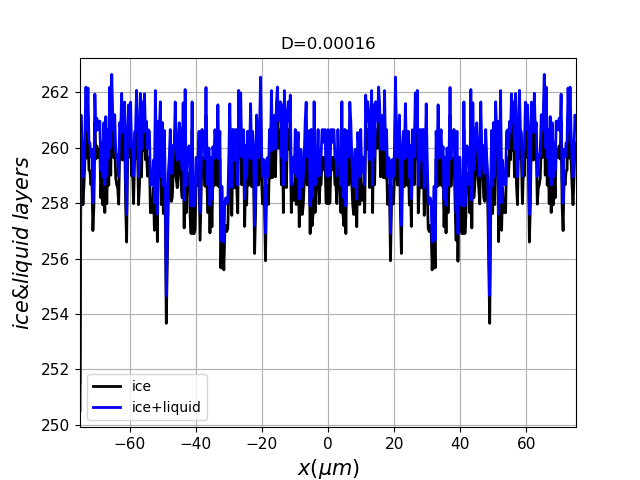

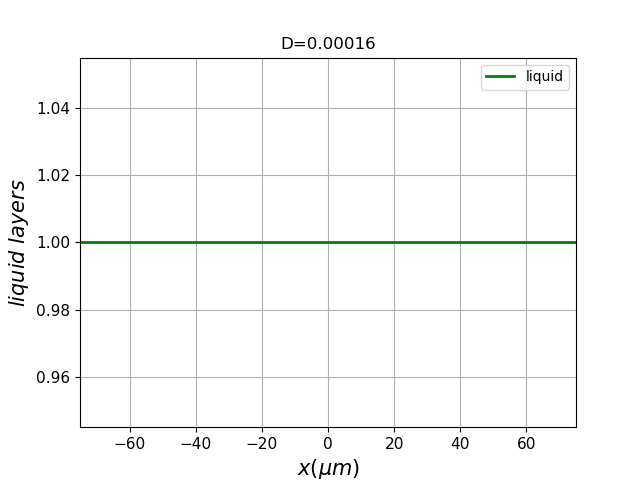

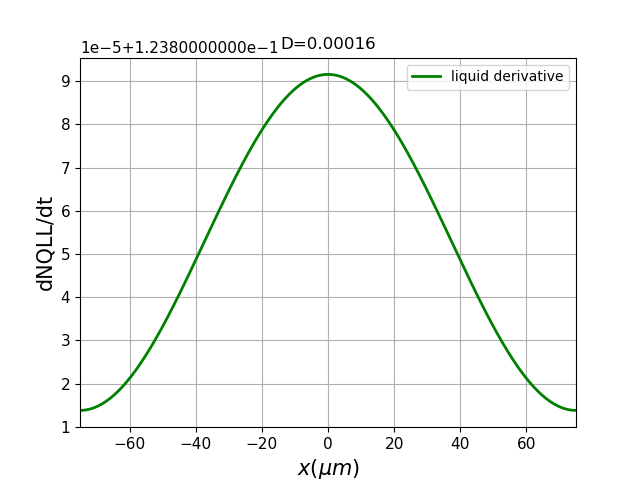

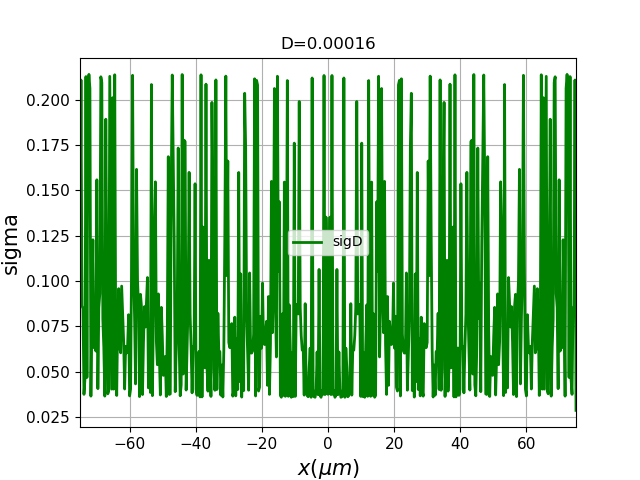

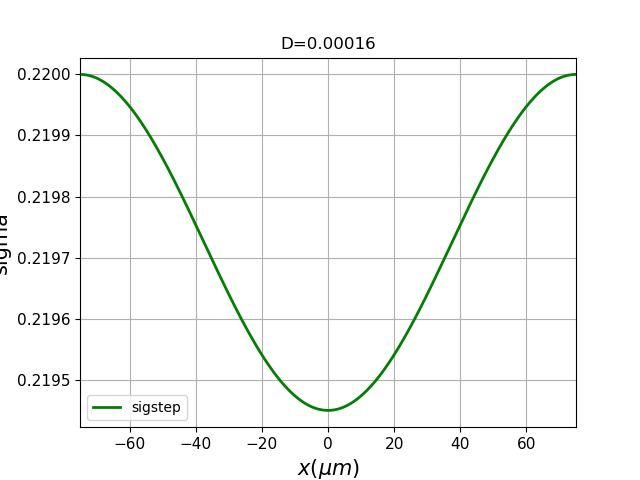

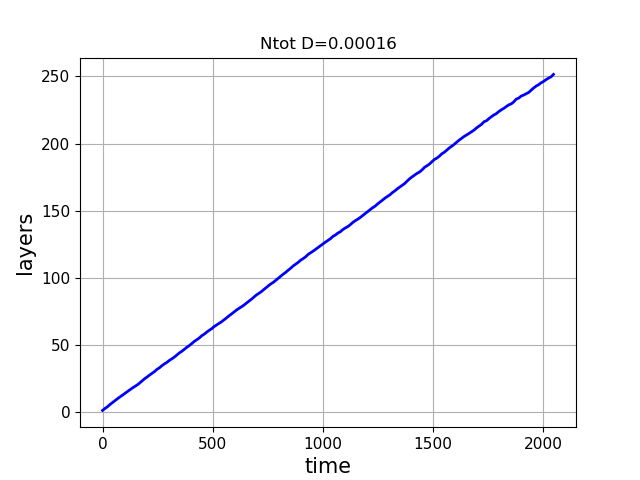

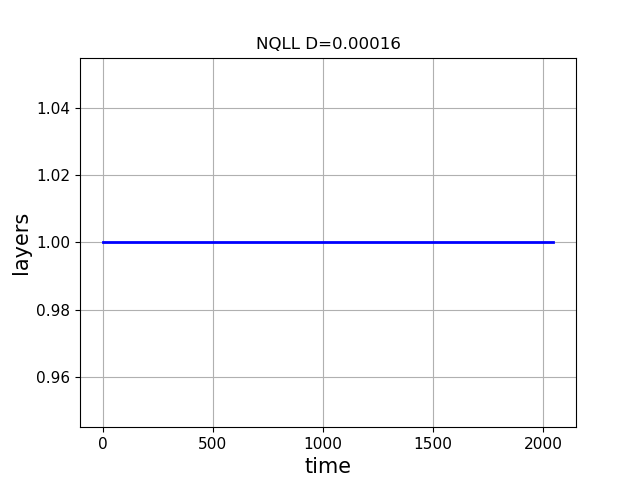

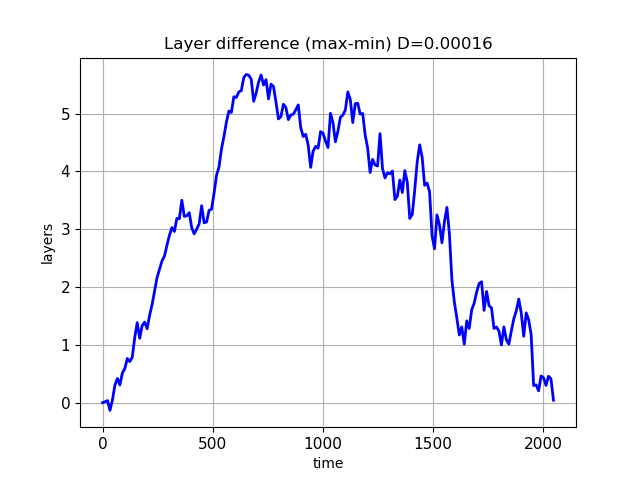

In [14]:
ticklabelsize = 11
fontsize = 15
linewidth = 2

print(len(Ntot),'Ntot')

# Growth statistics
sec1 = time.time()

# minpoint = min(Nice)
minpoint = 0
ncorner = 4
print("Height of Ice", minpoint)
delta_Ntot_entire = Ntot-Ntotkeep[0]
print( "1-D growth, corner", delta_Ntot_entire[ncorner])
print( "1-D growth, center", delta_Ntot_entire[nmid])
growthrate_entire = delta_Ntot_entire/ttot*umpersec_over_mlyperus
print( "1-D Modeled growth rate, corner, um/s", growthrate_entire[ncorner])
print( "1-D Modeled growth rate, corner, ml/us", growthrate_entire[ncorner]/umpersec_over_mlyperus)
print( "1-D Modeled growth rate, center, um/s", growthrate_entire[nmid])
alpha = growthrate_entire/nu_kin/sigmaI
print( "1-D Modeled alpha, corner", alpha[ncorner])
print( "1-D Modeled alpha, center", alpha[nmid])
print( "Difference, %", (alpha[nmid]-alpha[ncorner])/alpha[ncorner]*100)


# Comparisons with Libbrecht
sigma0_L = 0.08
A_L = .28
alpha_L = A_L*np.exp(-sigma0_L/sigmaIcorner)
print("Libbrecht's predicted growth rate, um/s", nu_kin*alpha_L*sigmaIcorner)
print("Libbrecht's predicted alpha", alpha_L)

# Timing statistics
sec2 = time.time()
print("Time taken:", int((sec2-sec1)/60), "min", (sec2-sec1)%60, "secs")

title = 'D='+str(D)

# Plot ice and liquid
plt.figure()
plt.plot(x-xmid, Nice-minpoint, 'k', label='ice', lw=linewidth)
plt.plot(x-xmid, NQLL+Nice-minpoint, 'b', label='ice+liquid', lw=linewidth)
plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
plt.ylabel(r'$ice & liquid \ layers$',fontsize=fontsize)
plt.xlim([-xmid, xmid])
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.legend()
plt.title(title)
plt.grid('on')

# Plot liquid only
plt.figure()
plt.plot(x-xmid, NQLL, 'g', label='liquid', lw=linewidth)
plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
plt.ylabel(r'$liquid \ layers$',fontsize=fontsize)
plt.xlim([-xmid, xmid])
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.legend()
plt.title(title)
plt.grid('on')

# Plot derivatives
dydx = f1d(ylast,np.zeros(nx),params)
# dydx = np.reshape(dydx,(2,nx))
plt.figure()
plt.plot(x-xmid, dydx[:], 'g', label='liquid derivative', lw=linewidth)
plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
plt.ylabel('dNQLL/dt',fontsize=fontsize)
plt.xlim([-xmid, xmid])
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.legend()
plt.title(title)
plt.grid('on')

# Plot sigma_m
sigD = f1d_sigma_m(ylast,np.zeros(nx),params)
plt.figure()
plt.plot(x-xmid, sigD, 'g', label='sigD', lw=linewidth)
plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
plt.ylabel('sigma',fontsize=fontsize)
plt.xlim([-xmid, xmid])
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.legend()
plt.title(title)
plt.grid('on')

# Plot sigma
plt.figure()
plt.plot(x-xmid, sigmaI, 'g', label='sigstep', lw=linewidth)
plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
plt.ylabel('sigma',fontsize=fontsize)
plt.xlim([-xmid, xmid])
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.legend()
plt.title(title)
plt.grid('on')

# The liquid over time
ix = 0
Ntotkeep_at_one_position = np.array(Ntotkeep)[:,ix]
plt.figure()
plt.plot(tkeep, Ntotkeep_at_one_position, 'b', label='total', lw=linewidth)
plt.xlabel('time',fontsize=fontsize)
plt.ylabel('layers',fontsize=fontsize)
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.grid('on')
plt.title('Ntot '+title)

# 
ix = 0
NQLLkeep_at_one_position = np.array(NQLLkeep)[:,ix]
plt.figure()
plt.plot(tkeep, NQLLkeep_at_one_position, 'b', label='liquid', lw=linewidth)
plt.xlabel('time',fontsize=fontsize)
plt.ylabel('layers',fontsize=fontsize)
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.grid('on')
plt.title('NQLL '+title)


Ntot_difference = np.array(Ntotkeep)[:,-1] - np.array(Ntotkeep)[:,nmid]
plt.figure()
plt.plot(tkeep, Ntot_difference, 'b', label='number of steps', lw=linewidth)
plt.xlabel('time')
plt.ylabel('layers')
plt.grid('on')
plt.title('Layer difference (max-min) '+title)

# simulation object testing

1D model for comparison (uses same parameters as above 2d model), graphing if it also reaching steady state

In [3]:
#set up and run and plot a new simulation
test_2d_asym = Simulation(ds.f2d, (500,500), method='RK45')
test_2d_asym_test = Simulation(df.f2d, (500,500), method='RK45')

test_2d_asym_test.mem_check = True
test_2d_asym_test.discretization_halt = False
test_2d_asym_test.noisy_init = False
test_2d_asym_test.layermax = 1000
test_2d_asym_test.sigmaIcorner = 0.20
test_2d_asym_test.center_reduction = 0.15


#turn on memory handling logic
test_2d_asym.mem_check = True
#test_2d_asym.memory_threshold = 100E9 #100GB - default

test_2d_asym.discretization_halt = False

#try a noisy simulation
test_2d_asym.noisy_init = False

#test_2d_asym.float_params['DoverdeltaX2'] *= 2 
test_2d_asym.layermax = 1000
#test_2d_asym.sigmastepmax= -0.01#ablation
test_2d_asym.sigmaIcorner= 0.20 #growth
test_2d_asym.center_reduction = 0.15
#test_2d_asym.deltaT *= 10 #increase time step to decrease number of steps saved

#_plot = test_2d_asym.plot(tot=True,completion=1)
#anim = test_2d_asym.animate(ice=True,surface=True, ret=True, focus_on_growth=True)

In [4]:
#create 1d sim and graph number of steps over time
## model, shape, method, rtol initiaized here
ss_1d = Simulation(ds.f1d, (501,), method=test_2d_asym.method, rtol=test_2d_asym.rtol)
ss_1d_test = SimulationNew(df.f1d, (501,), method=test_2d_asym.method, rtol=test_2d_asym.rtol)

## everything else initialized
# ss_1d_test.float_params['DoverdeltaX2'] = test_2d_asym_test.float_params['DoverdeltaX2']
# ss_1d_test.layermax = 15000
# ss_1d_test.sigmaIcorner = 0.25 ##test_2d_asym_test.sigmaIcorner
# ss_1d_test.sigma0 = test_2d_asym_test.sigma0
# ss_1d_test.center_reduction = test_2d_asym_test.center_reduction
# ss_1d_test.deltaT = test_2d_asym_test.deltaT
# ss_1d_test.noisy_init = test_2d_asym_test.noisy_init

# ss_1d.float_params['DoverdeltaX2'] = test_2d_asym.float_params['DoverdeltaX2'] 
# #ss_1d.layermax = test_2d_asym.layermax * 1.5 #make sure it reaches steady state
# ss_1d.layermax = 1000
# ss_1d.sigmaIcorner = test_2d_asym.sigmaIcorner 
# ss_1d.sigma0 = test_2d_asym.sigma0
# ss_1d.center_reduction = test_2d_asym.center_reduction
# ss_1d.deltaT = test_2d_asym.deltaT #increase time step to decrease number of steps saved?
# ss_1d.noisy_init = test_2d_asym.noisy_init


-1 1 0.0005211413851720081
99 13 0.0508201348391637
199 25 0.0595611752869587
299 37 0.10289727121431724
399 50 0.2687674583587807
499 62 0.7176756713335379
599 74 0.9092950568338836
699 86 0.9553929983464684
799 98 0.9724416821446908
899 111 1.031479450947728
999 123 1.0784270443578237
1099 135 1.077418556909521
1199 147 1.123048416981419
1299 159 1.2880788904068368
1399 172 1.7194495431531323
1499 184 1.9195496386583386
1599 196 1.9650016190520603
1699 208 1.985327838084089
1799 221 2.0551192595631846
1899 233 2.117025015263323
1999 245 2.1022455798428155
2099 257 2.151749835092545
2199 269 2.3176946151605193
2299 282 2.716991065682066
2399 294 2.927136764480963
2499 306 2.9676309898226236
2599 318 2.989468723129505
2699 330 3.0175627524792503
2799 342 3.0495340262148147
2899 354 3.0471371511741836
2999 366 3.084887239296961
3099 378 3.106621144512758
3199 390 3.124826892032388
3299 402 3.1489689360383863
3399 414 3.2401842653498534
3499 426 3.277155761005929
3599 438 3.2796297422806

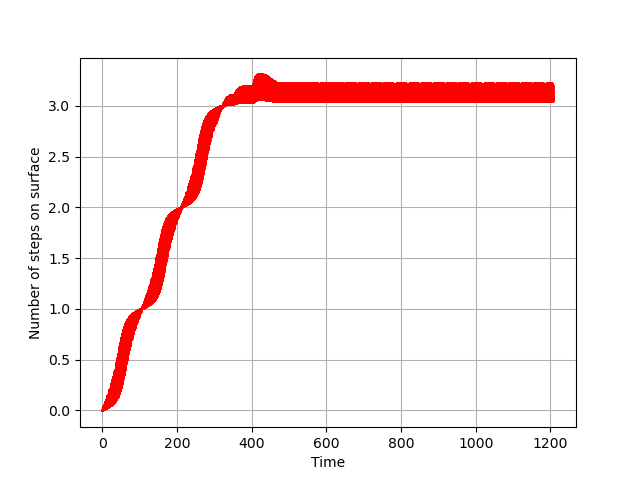

In [5]:
# plot number of steps over time
# fig,axs = plt.subplots(2)
# ax = axs[0]
# ax2 = axs[1]

# Ntot = ss_1d.getNtot()
NtotTest = ss_1d_test.getNtot()

# maxes = np.array([np.max(n) for n in Ntot[:]])
# mins = np.array([np.min(n) for n in Ntot[:]])
maxes1 = np.array([np.max(n) for n in NtotTest[:]])
mins1 = np.array([np.min(n) for n in NtotTest[:]])

#print(maxes,mins)

fig,ax = plt.subplots()

# ax.plot(test_f2d_sim.results()['t'],maxes-mins)
# ax.plot(Ntot[:,0],maxes-mins,color='blue',label='original')
ax.plot(NtotTest[:],maxes1-mins1,color='red')#,linestyle=':',label='Testing')

#ax2.plot(NtotTest[:100],(maxes1-mins1)[:100],color='red',linestyle=':')
#ax2.plot(Ntot[:100],(maxes1-mins1)[:100],color='blue')

#for ax in axs:
ax.set_ylabel('Number of steps on surface')
ax.set_xlabel('Time')
# ax2.set_ylabel('Number of steps on surface')
# ax2.set_xlabel('Time')
plt.grid()
plt.show()





In [ ]:
ss_1d_test.animate()

NameError: name 'ss_1d_test' is not defined

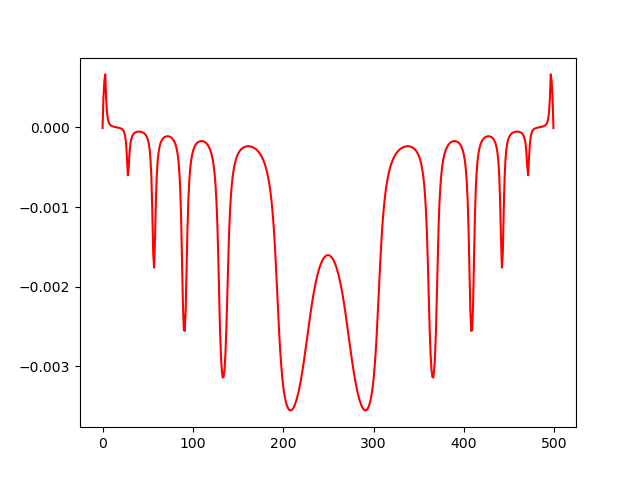

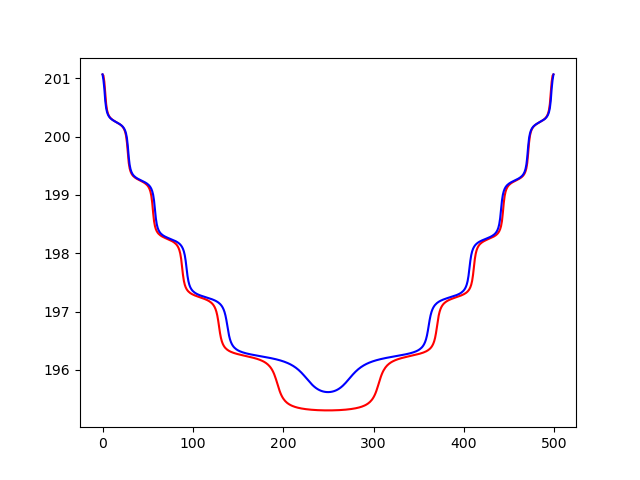

In [22]:
fig,ax = plt.subplots()
ax.plot((NtotTest[-1,:]-Ntot[-1,:])/Ntot[-1,:],color = "red")

fig,ax = plt.subplots()
ax.plot(NtotTest[-1,:],color = "red")
ax.plot(Ntot[-1,:],color = "blue")

500 324
(324, 500) (324, 500) (324, 500)
500 324
(324, 500) (324, 500) (324, 500)


C:\Users\elsla\AppData\Local\Temp\ipykernel_38676\4106757936.py:36: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contour(X=xs, Y=ys, Z=zs,  label='ice+QLL')#, cmap='viridis_r')


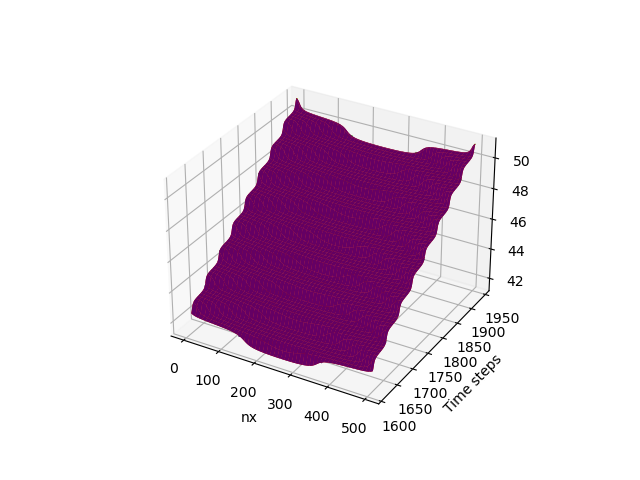

In [ ]:
plt.close('1d surface over time 3d surface')
plt.figure('1d surface over time 3d surface')
#plot surface over time as 3d surface
ax = plt.axes(projection='3d')

zss = ss_1d_test.getNtot()
start,stop = 0,zss.shape[0]
start,stop = stop*5//6, stop
zss = zss[start:stop]
tt,xx = [*zss.shape]
print(xx,tt)
xss,yss = np.meshgrid(np.linspace(0,xx,xx),np.linspace(start,stop,stop-start))
print(xss.shape,yss.shape,zss.shape)
levels = np.linspace(740,880,10)
ax.contour(X=xss,Y=yss,Z=zss)
ax.plot_surface(X=xss,Y=yss,Z=zss,color='purple')


zs = ss_1d.getNtot()
start,stop = 0, zs.shape[0]
#crop time selection
start,stop = stop*5//6, stop
zs = zs[start:stop]

t,x = [*zs.shape]
print(x,t)
xs,ys = np.meshgrid(np.linspace(0,x,x),np.linspace(start,stop,stop-start))

#print shapes of inputs
print(xs.shape,ys.shape,zs.shape)

#contour levels
levels = np.linspace(740,880,10)

#plot contours of the surface
ax.contour(X=xs, Y=ys, Z=zs,  label='ice+QLL')#, cmap='viridis_r')

#plot the surface with reversed viridis
ax.plot_surface(X=xs, Y=ys, Z=zs,  label='ice+QLL',color='red')#, cmap='viridis_r')

ax.set_xlabel('nx')
ax.set_ylabel('Time steps')
#ax.set_xlabel(r'x ($\mu m$)')
#ax.set_ylabel('Layers of ice')
plt.show()

500 19866
(19866, 500) (19866, 500) (19866, 500)


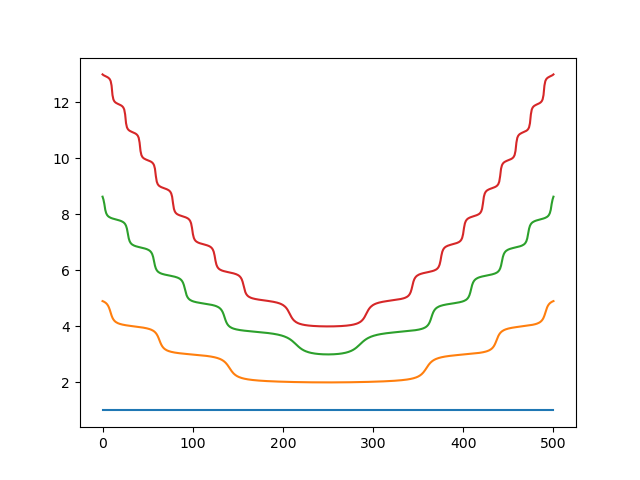

In [ ]:
#plot contours over time on one surface
ax = plt.axes(projection='3d')

zs = ss_1d.getNtot()
start,stop = 0, zs.shape[0]
#crop time selection
#start,stop = stop*5//6, stop
zs = zs[start:stop]

t,x = [*zs.shape]
print(x,t)
xs,ys = np.meshgrid(np.linspace(0,x,x),np.linspace(start,stop,stop-start))

#print shapes of inputs
print(xs.shape,ys.shape,zs.shape)

# #contour levels
# levels = np.linspace(740,880,10)

# #plot the surface with reversed viridis
# ax.contour(X=xs, Y=ys, Z=zs,  label='ice+QLL', cmap='viridis_r')

# ax.set_xlabel('nx')
# ax.set_ylabel('Time steps')
# #ax.set_xlabel(r'x ($\mu m$)')
# #ax.set_ylabel('Layers of ice')
# plt.show()

ix = 100
plt.figure()

ixlist = [0, 4_000, 8_000, 16_000]#np.linspace(0,7400, 100)
offset = 1
for ix in ixlist:
    tempzs = zs[ix,:] - min(zs[ix,:]) + offset
    offset += 1
    plt.plot(xs[ix,:], tempzs,label = 'x = '+str(ix))

#plt.legend()

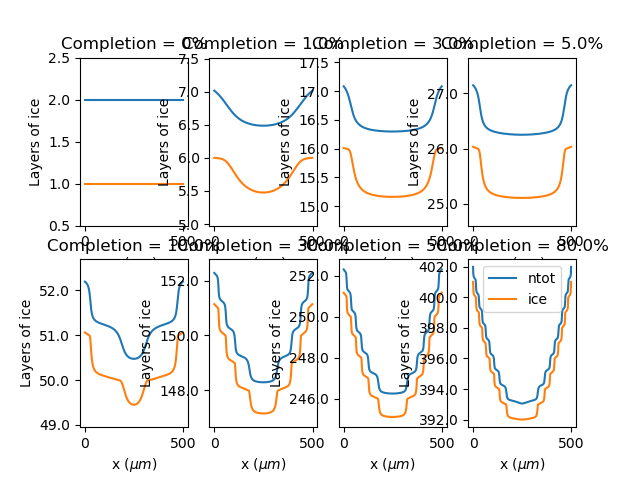

In [ ]:
#plot the surface over time on subplots

#run the simulation
ntot = ss_1d.getNtot()
nice = ss_1d.getNice()

#plot the surface over time on subplots
fig, axs = plt.subplots(2, 4)
for i, cmpltion in enumerate([0,0.01,0.03,0.05,0.1,0.3,0.5,0.8]):
#for i, cmpltion in enumerate([0.1,0.12,0.15, 0.18,0.2,0.23,0.26,0.3]):

    xs = ntot[int(cmpltion*ntot.shape[0]),:]
    ice = nice[int(cmpltion*nice.shape[0]),:]
    axs[i//4, i%4].set_xlabel(r'x ($\mu m$)')
    axs[i//4, i%4].set_ylabel('Layers of ice')
    axs[i//4, i%4].set_ylim(bottom=min(ice)-.5, top=max(xs)+.5)
    axs[i//4, i%4].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    axs[i//4, i%4].set_title('Completion = '+str(cmpltion*100)+'%')
    axs[i//4, i%4].plot(xs, label='ntot')
    axs[i//4, i%4].plot(ice, label='ice')

plt.legend()
plt.show()

In [ ]:
# import csv

# # Get x, xs, ice at steady state (for reference 1D system)
# xs = ntot[int(ntot.shape[0])-1, :]
# ice = nice[int(nice.shape[0])-1, :]

# # Generate the range of x values from -250 to 250
# x = range(-250, 251)

# # Create a list of lists containing x, xs, and ice values
# data = [[xi, xsi, icei] for xi, xsi, icei in zip(x, xs, ice)]

# # Write the data to a CSV file
# with open('data/output.csv', 'w', newline='') as csvfile:
#     writer = csv.writer(csvfile)
#     writer.writerow(['x', 'ntot', 'nice'])  # Write header row
#     writer.writerows(data)  # Write data rows


FileNotFoundError: [Errno 2] No such file or directory: 'data/output.csv'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


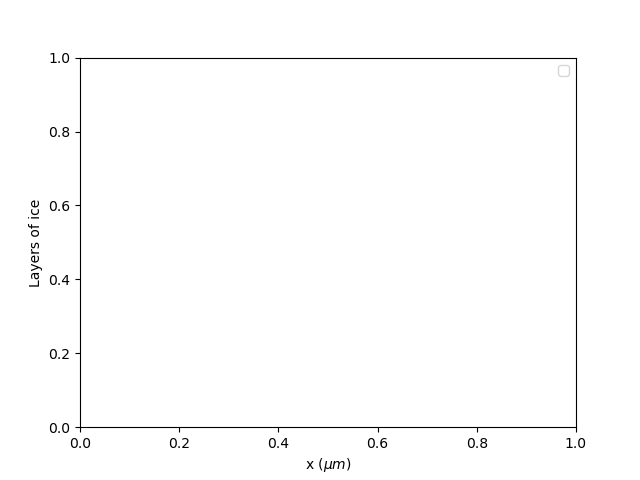

In [ ]:
ss_1d.animate()

In [ ]:
plt.close()


0D model for comparison (uses same parameters as above 2d model)

In [ ]:
#create 1d sim and graph number of steps over time
#ss_1d = Simulation(f1d, (test_2d_asym.shape[0],), method=test_2d_asym.method, rtol=test_2d_asym.rtol)
ss_0d = Simulation(ds.f0d, (1,), method=test_2d_asym.method, rtol=test_2d_asym.rtol)

# NOTE: 0d ablation sim halting is not implemented...
ss_0d.uselayers = False
ss_0d.countermax = 1750 #about 10 layers

ss_0d.float_params['DoverdeltaX2'] = test_2d_asym.float_params['DoverdeltaX2'] 
#ss_1d.layermax = test_2d_asym.layermax * 1.5 #make sure it reaches steady state
ss_0d.layermax = 10 
#ss_0d.sigmastepmax = test_2d_asym.sigmastepmax 
ss_0d.sigmastepmax = -0.01
ss_0d.sigma0 = test_2d_asym.sigma0
ss_0d.center_reduction = test_2d_asym.center_reduction
ss_0d.deltaT = test_2d_asym.deltaT #increase time step to decrease number of steps saved?
ss_0d.noisy_init = test_2d_asym.noisy_init

In [ ]:
print(ss_0d.sigmastepmax)
print(ss_0d.sigma0)

-0.01
0.19


In [ ]:
#run the sim, get results
#nice_0d = ss_0d.getNice() #NOTE: current version of getNice() returns a 2d array
ntot_0d = ss_0d.getNtot()
fliq_0d = ss_0d.getFliq()
nice_0d = ntot_0d - fliq_0d

breaking because reached max number of iterations


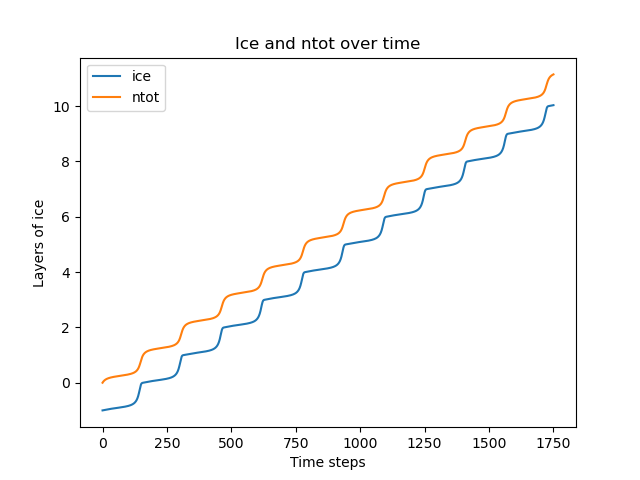

In [ ]:
#plot ice and ntot over time
fig = plt.figure()
ax = plt.axes()
ax.set_xlabel('Time steps')
ax.set_ylabel('Layers of ice')
ax.set_title('Ice and ntot over time')
ax.plot(nice_0d, label='ice')
ax.plot(ntot_0d, label='ntot')
plt.legend()
plt.show()

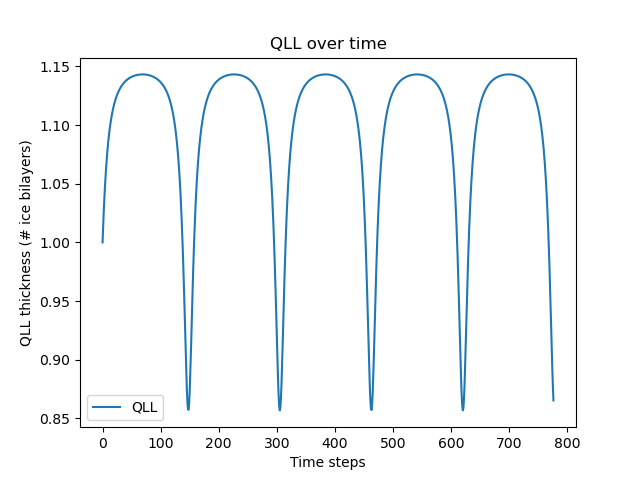

In [ ]:
#plot QLL over time (illustrates microsurfaces), diffusive slowdown
fig = plt.figure()
ax = plt.axes()
ax.set_xlabel('Time steps')
ax.set_ylabel('QLL thickness (# ice bilayers)')
ax.set_title('QLL over time')
ax.plot(fliq_0d[:777], label='QLL')
plt.legend()
plt.show()


In [ ]:
test_2d_sim.save(id=['august13'])

NameError: name 'test_2d_sim' is not defined

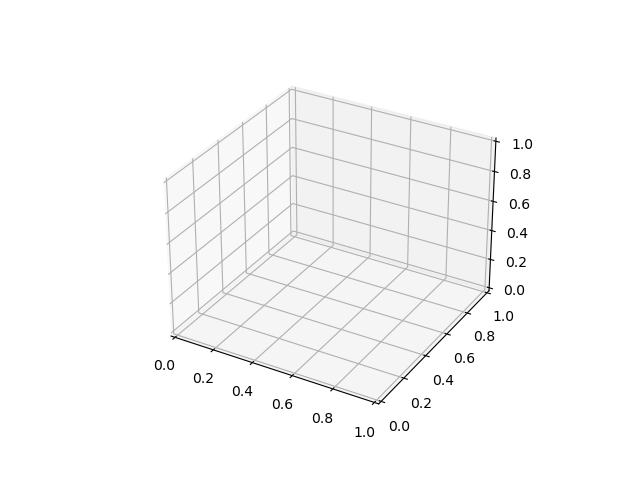

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')
num_steps = len(test_2d_sim.results()['t'])
xs,ys = np.meshgrid(test_2d_sim.x, test_2d_sim.y)
ax.plot_surface(X=xs, Y=ys, Z=test_2d_sim.getNtot()[num_steps-1], cmap='viridis')

In [ ]:
test_1d = SimulationNew(df.f1d, shape=(500,), rtol=1e-12)
test_1d.layermax = 500
test_1d.results()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


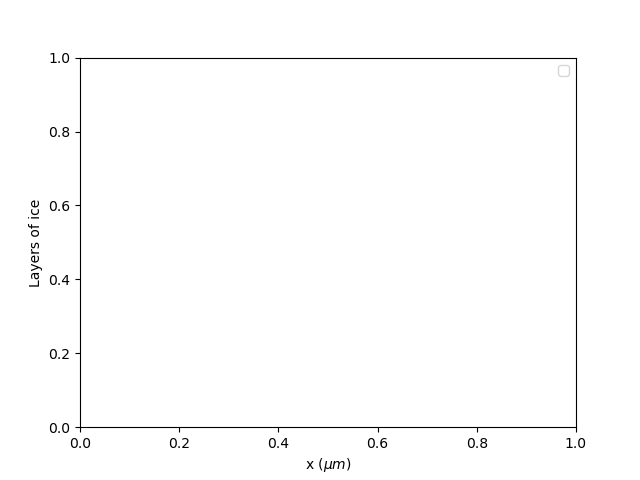

In [ ]:
test_1d.animate(ice=True, tot=True)
#test_1d.plot()

# using prices tests for diffusion

In [16]:
niter = 1

# simulation timesteps
tinterval = np.arange(0,200000,1000)

# Message
print("Starting a new system")
nx = 501 # Number of points in simulation box
ny = 512

xmax = 150
ymax = 50

##############
## 1d setup ##

xrange = np.linspace(0, xmax, nx)
boxpoints = len(xrange)
deltaX = xrange[1]-xrange[0]
nmid = int(nx/2)
nquart = int(nx/4)
# Initialize as a pre-equilibrated layer of liquid over ice
Nice0 = np.ones(boxpoints) # begin with one layer of ice
#Adding noise to test stability of system (-Max, 6/27/2020)
#Nice += np.random.normal(0,0.01,nx)
xmid = max(xrange)/2
xmax = xrange[nx-1]
##############

##############
## 2d setup ##

# xrange = np.linspace(0,xmax,nx)
# yrange = np.linspace(0,ymax,ny)
# xx,yy = np.meshgrid(xrange,yrange)

# deltaX = xrange[1]-xrange[0]
# deltaY = yrange[1]-yrange[0]

# # Lay out the system
# nymid = int(ny/2)
# nyquart = int(ny/4)

# # Initialize as a pre-equilibrated layer of liquid over ice
# Nice0 = np.ones_like(xx) # begin with one layer of ice
# #Adding noise to test stability of system (-Max, 6/27/2020)
# #Nice += np.random.normal(0,0.01,nx)

# xmid = max(xrange)/2
# xmax = xrange[nx-1]
# ymid = max(yrange)/2
# ymax = yrange[ny-1]



##############

Nbar = 1.0 # new Nbar from VMD, 260K
Nstar = .9/(2*np.pi)



NQLL0 = Nbar + Nstar * np.sin(2*np.pi*(Nice0 - Nbar)) # initialize quasi-liquid layer  
Ntot0 = NQLL0 + Nice0

Starting a new system


In [15]:
#Time and diffusion parameters
# Just conversions
nmpermonolayer = 0.3
umpersec_over_mlyperus = (nmpermonolayer/1e3*1e6)

# Diffusion coefficient
D = 1.6e-4 # micrometers^2/microsecond

# Time steps
# dtmaxtimefactor = 10
dtmaxtimefactor = 50
dtmax = deltaX**2/D
deltaT = dtmax/dtmaxtimefactor

# Deposition rate
nu_kin = 250 # microns/second
deprate = nu_kin/umpersec_over_mlyperus # monolayers per microsecond
deprate_times_deltaT = deprate * deltaT

# Supersaturation
sigma0 = 0.19
sigmastepmax = 0.20 #-0.10 # Must be bigger than sigma0 to get growth, less than 0 for ablation
center_reduction = 0.25 #0.25 # In percent
c_r = center_reduction/100

# Diffusion coefficient scaled for this time-step and space-step
# DoverdeltaY2 = D/deltaY**2
DoverdeltaX2 = D/deltaX**2

# Gets the function sigma(x)
sigmastep = getsigmastep(xrange,xmax,center_reduction,sigmastepmax)

In [16]:
# Reporting
print("D =", D, 'um^2/us',D * 1e-12*1e6*1e9, 'x 10^-9 m^2/sec') # diffusion
print('deprate =', deprate, 'monolayers/us') # deposition rate
#print('nmid', nmid) # midpoint
print('N*', Nstar) # N^*
print('N*x2pi', Nstar*2*np.pi) # 2 pi N^*
print('Nbar, Nbar-N*, N*/Nbar', Nbar, Nbar-Nstar, Nstar/Nbar) # N average (what is N?) and deviation
print('deltaX', deltaX) # spatial step size
print('sigma_0 =', sigma0) # supersaturation default
print('sigmastepmax =', sigmastepmax) # deviation from default
print('center reduction', center_reduction, '%') # reduction of supersaturation in the center
print('max growth rate =', deprate*sigmastepmax*umpersec_over_mlyperus, 'um/sec') # max growth rate (edge)
print('min growth rate =', deprate*(sigmastepmax-sigma0)*umpersec_over_mlyperus, 'um/sec') # min growth rate (center)
print('nu_kin =', nu_kin, 'um/sec') # nu-kinetic

D = 0.0002 um^2/us 0.2 x 10^-9 m^2/sec
deprate = 0.16333333333333333 monolayers/us
N* 0.1432394487827058
N*x2pi 0.9
Nbar, Nbar-N*, N*/Nbar 1.0 0.8567605512172942 0.1432394487827058
deltaX 0.09784735812133072
sigma_0 = 0.19
sigmastepmax = 0.2
center reduction 0.25 %
max growth rate = 9.8 um/sec
min growth rate = 0.49000000000000044 um/sec
nu_kin = 49 um/sec


In [17]:
# This is the 1-d run
# Bundle parameters for ODE solver
float_params = np.array([Nbar, Nstar, sigma0, deprate, DoverdeltaX2])#, DoverdeltaY2])
int_params = np.array([0,nx])
#int_params2 = np.array([(0,nx),(0,ny)])

# Initial conditions for ODE solver

## 0d test
# out = solve_ivp(f0dNew, t_span = [tinterval[0],tinterval[-1]], t_eval = tinterval, y0 = Ntot0[0]-NQLL0[0], args=(float_params,sigmastep),rtol=1e-12)
# outOld = solve_ivp(f0dOld, t_span = [tinterval[0],tinterval[-1]], t_eval = tinterval, y0 = np.concatenate([NQLL0,Ntot0]), args=(float_params,int_params,sigmastep),rtol=1e-12)

## 1d test
out = solve_ivp(f1dNew, t_span = [tinterval[0],tinterval[-1]], t_eval = tinterval, y0 = Ntot0-NQLL0, args=(float_params,sigmastep),rtol=1e-12)
outOld = solve_ivp(f1dOld, t_span = [tinterval[0],tinterval[-1]], t_eval = tinterval, y0 = np.concatenate([NQLL0,Ntot0]), args=(float_params,int_params,sigmastep),rtol=1e-12)

## 2d test still getting errors here
# out = solve_ivp(f2dNew, t_span = [tinterval[0],tinterval[-1]], t_eval = tinterval, y0=Ntot0[0][0]-NQLL0[0], args=(float_params,int_params2,sigmastep),rtol=1e-12)
# outOld = solve_ivp(f2dOld, t_span = [tinterval[0],tinterval[-1]], t_eval = tinterval, y0 = np.concatenate([NQLL0,Ntot0]), args=(float_params,int_params2,sigmastep),rtol=1e-12)


In [15]:
float_params = np.array([Nbar, Nstar, sigma0, deprate, DoverdeltaX2])
int_params = np.array([0,nx])


##Nice0Rand = np.random.random(Ntot0.shape)
x = np.arange(0,2*np.pi,2*np.pi/512)

Nice0Rand = np.sin(x)
NQLL0Rand = Nbar + Nstar * np.sin(2*np.pi*(Nice0Rand - Nbar))
Ntot0Rand = Nice0Rand + NQLL0Rand

initialDerivNew = ds.f1d(0,Nice0Rand, float_params, sigmastep)
initialDerivOld = df.f1d(0, np.concatenate([NQLL0Rand,Ntot0Rand]), float_params, int_params, sigmastep)

##initialDerivNew - initialDerivOld[512:]

fig,ax = plt.subplots()
ax.plot(initialDerivNew[0:40],color='red')
ax.plot(initialDerivOld[512:552],color='blue',linestyle='--')

fig2,ax2 = plt.subplots()
ax2.plot((initialDerivNew[:] - initialDerivOld[512:])/initialDerivOld[512:])

NameError: name 'Nbar' is not defined

Text(0.5, 1.0, '3: alpha')

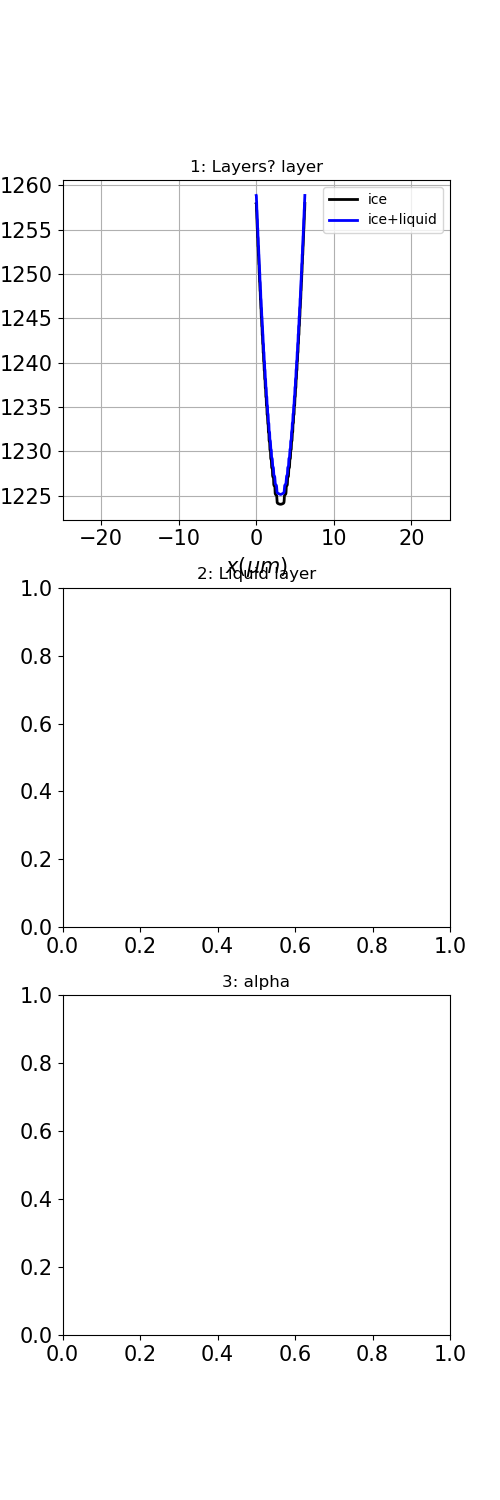

In [19]:
ticklabelsize = 15
fontsize = 15
linewidth = 2
fignum = 0


NQLLOld = outOld.y[0:nx]
NtotOld = outOld.y[nx:]
NiceOld = NtotOld - NQLLOld
Ntot = out.y
NQLL = Nbar + Nstar * np.sin(2*np.pi*(Ntot - Nbar))
Nice = Ntot - NQLL

NtotFinalOld = NtotOld[:,-1]
NQLLFinalOld = NQLLOld[:,-1]
NiceFinalOld = NiceOld[:,-1]
NtotFinal = Ntot[:,-1]
NQLLFinal = NQLL[:,-1]
NiceFinal = Nice[:,-1]

# Growth statistics
minpoint = min(NiceFinal)
minpointOld = min(NiceFinalOld)
# ncorner = 4 # why is ncorner 4 and not 0?

# # total height of ice
# print("Height of Ice", minpoint)

# # change in total ice depth at each grid point
delta_Ntot_entire = NtotFinal-Ntot[:,0]
delta_Ntot_entireOld = NtotFinalOld-NtotOld[:,0]

# # growth at corner and in center
# print( "1-D growth, corner", delta_Ntot_entire[ncorner])
# print( "1-D growth, center", delta_Ntot_entire[nmid])

# # growth over time (growth rate)
growthrate_entire = delta_Ntot_entire/out.t[-1]*umpersec_over_mlyperus
growthrate_entireOld = delta_Ntot_entireOld/outOld.t[-1]*umpersec_over_mlyperus
# print( "1-D Modeled growth rate, corner, um/s", growthrate_entire[ncorner])
# print( "1-D Modeled growth rate, corner, ml/us", growthrate_entire[ncorner]/umpersec_over_mlyperus) # why different units on this one?
# print( "1-D Modeled growth rate, center, um/s", growthrate_entire[nmid])

# # alpha is some other modified growth rate
alpha = growthrate_entire/nu_kin/sigmastep
alphaOld = growthrate_entireOld/nu_kin/sigmastep
# print( "1-D Modeled alpha, corner", alpha[ncorner])
# print( "1-D Modeled alpha, center", alpha[nmid])
# print( "Difference, %", (alpha[nmid]-alpha[ncorner])/alpha[ncorner]*100)

# # Comparisons with Libbrecht
# sigma0_L = 0.08
# A_L = .28
# alpha_L = A_L*np.exp(-sigma0_L/sigmastepmax)
# print("Libbrecht's predicted growth rate, um/s", nu_kin*alpha_L*sigmastepmax)
# print("Libbrecht's predicted alpha", alpha_L)

#########
# Plots #
#########

fig,axs = plt.subplots(3,1,figsize=(5,15))

# First plot: layers (rescaled to have minimum at zero, shifted so center of facet is at zero)
fignum +=1
axs[0].set_title(str(fignum)+': Layers? layer')
# axs[0].plot(x-xmid, NiceFinal-minpoint, 'k', label='ice', lw=linewidth)
# axs[0].plot(x-xmid, NtotFinal-minpoint, 'b', label='ice+liquid', lw=linewidth)
axs[0].plot(x, NiceFinal, 'k', label='ice', lw=linewidth)
axs[0].plot(x, NtotFinal, 'b', label='ice+liquid', lw=linewidth)

axs[0].set_xlabel(r'$x (\mu m$)',fontsize=fontsize)
axs[0].set_ylabel(r'$ice \ layers$',fontsize=fontsize)
axs[0].set_xlim([-xmid, xmid])
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
axs[0].legend()
axs[0].grid('on')

# Second plot: liquid layer alone
fignum +=1
axs[1].set_title(str(fignum)+': Liquid layer')
# axs[1].plot(x-xmid, NQLLFinal, 'g', label='liquid', lw=linewidth)
# axs[1].set_xlabel(r'$x (\mu m$)',fontsize=fontsize)
# axs[1].set_ylabel(r'$ice \ layers$',fontsize=fontsize)
# axs[1].set_xlim([-xmid, xmid])
# rcParams['xtick.labelsize'] = ticklabelsize 
# rcParams['ytick.labelsize'] = ticklabelsize
# axs[1].legend()
# axs[1].grid('on')

# Third plot: alpha (a measure of growth rate at each point)
fignum +=1
axs[2].set_title(str(fignum)+': alpha')
# axs[2].plot(x-xmid, alpha, 'k', lw=linewidth)
# axs[2].set_xlabel(r'$x (\mu m$)',fontsize=fontsize)
# axs[2].set_ylabel(r'$ \alpha $',fontsize=fontsize)
# rcParams['xtick.labelsize'] = ticklabelsize 
# rcParams['ytick.labelsize'] = ticklabelsize
# axs[2].grid('on')


belongs under >Experiments...1D model for comparison +3 code cells>

1d simulation 